# The Dining Problem

Math 100, Spring 2021

_Will Kaufman, Ivy Yan_

June 4, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.dpi'] = 150  # 72

# Problem statement

For this problem we are assuming normal, non-COVID times. Each night during an academic year a student decides where to eat dinner. She has a choice of 3 dining venues (Foco, Collis, and Hop) and is indifferent between all of them. However, she is busy and wants to minimize the time she waits for food. If the wait time $T_W^{(i)}$ at venue $i$ follows a Poisson distribution with unknown parameter $\lambda_i$
$$
T_W^{(i)} \sim \text{Pois}(\lambda_i)
$$
what strategy would minimize the student's wait time for meals over the course of the entire academic year?

This formulation of the dining problem is exactly a multi-armed bandit problem.

# Multi-armed bandits

![From @slot_machine.](graphics/slot-machine.jpg){width=50%}



Multi-armed bandits were originally introduced by [@thompson1933likelihood; @thompson1934; @robbins1952some] as a "sequential design of experiments." Each "experiment" involves a decision to sample from one of many unknown probability distributions, and the goal is to maximize the sum of samples drawn from the distributions. For finitely many decisions, there are limited resources (the decisions to sample from one distribution) that must be allocated to maximize the expected sum. As a consequence, there must be a balance of _exploration_ of the multiple distributions and _exploitation_ of information gathered so far.

Multi-armed bandits arise in a variety of contexts. The name itself is an extension of a one-armed bandit (i.e. a slot machine) where one can choose between multiple slot machines which may have different payoff schemes. The initial research into multi-armed bandits was motivated by drug efficacy trials [@thompson1933likelihood; @thompson1934] and industrial quality control [@robbins1952some]. Multi-armed bandits also manifest in allocating research funding for clinical trials, deciding which department to take courses in at college, and the dining problem we introduce above.

The general multi-armed bandit problem features a set of $K$ real-valued probability distributions $B = \{B_1, B_2, \dots, B_K \}$ with means $\mu_1, \mu_2, \dots, \mu_K$. A particular distribution $B_k$ is chosen to be sampled at timestep $t$, which is referred to as the action $a_t = k$. The corresponding sample is the _reward_ $r_t$. The goal of the multi-armed bandit problem is to maximize the total rewards over $T$ timesteps.
The _regret_ after $t$ decisions is defined as

$$\rho=t\mu_* - \sum_{i=1}^t r_i$$

where $\mu_* = \max_k \{ \mu_k \}$. Informally, regret measures how much worse the decisions were compared to the expected optimal policy (i.e. sampling the distribution with highest mean $t$ times).

It is often helpful to define a function that maps actions (i.e. decisions to sample from a particular distribution) to the expected reward. This function is referred to as the action-value function or the Q function.
If we knew the means of each distribution, the Q function would simply be
$$
q_*(a = k) = \mathbb{E}[r | a = k] = \mu_k
$$
Because the expected values are not known, we instead estimate $Q_t(a)$ and iteratively update the estimates as more samples are realized. For a given $Q_t$, an action can be selected to _exploit_ the information so far by
$$
a_t = {\arg \max}_k Q_t(k)
$$
This does not take into account any uncertainty in the estimates given by $Q_t$.

For the dining problem, the student wishes to minimize her total wait time, so the rewards can be defined as

$$r_t = -T_W^{(i)}$$

By maximizing rewards, she minimizes wait time. This in turn corresponds to maximizing $q_*$.

# Problem setup

We explored a version of the dining problem modeled after Dartmouth College's dining venues: Class of 1953 Commons (or "Foco"), Collis Café ("Collis"), and Courtyard Café ("Hop")[^1]. Unfortunately, there is no data available on actual wait times at these venues, so we assigned the Poisson parameters qualitatively: Foco has the lowest wait time ($\lambda_1 = 4$), then the Hop ($\lambda_2 = 5$), then Collis ($\lambda_3 = 6$).

[^1]: There are technically other dining venues such as Novack Café, but the three venues above are the only places to get a truly quality meal.

Using these Poisson parameter values, random wait times were sampled for each venue for $3 \cdot 70 = 210$ days (meant to represent the academic year) and for 1000 simulations. These wait times were stored in the $1000 \times 210 \times 3$ `wait_times` array.

In [28]:
lambdas = np.array([4, 5, 6])
wait_times = np.random.poisson(lam=lambdas, size=(1000, 70*3, lambdas.size))

The following plot shows the wait times at each dining venue for a single simulation. While there is a high degree of overlap in the wait times, it is possible to see that Foco has a lower mean wait time than Hop, which is lower than Collis.

In [34]:
# plt.plot(wait_times[0, :, 0], marker='o', linestyle='none', alpha=.5, label='Foco')
# plt.plot(wait_times[0, :, 1], marker='o', linestyle='none', alpha=.5, label='Hop')
# plt.plot(wait_times[0, :, 2], marker='o', linestyle='none', alpha=.5, label='Collis')
# plt.legend()
# plt.title('Wait times (simulation 0)')
# plt.xlabel('Day')
# plt.ylabel('Wait time (minutes)')

# plt.show()

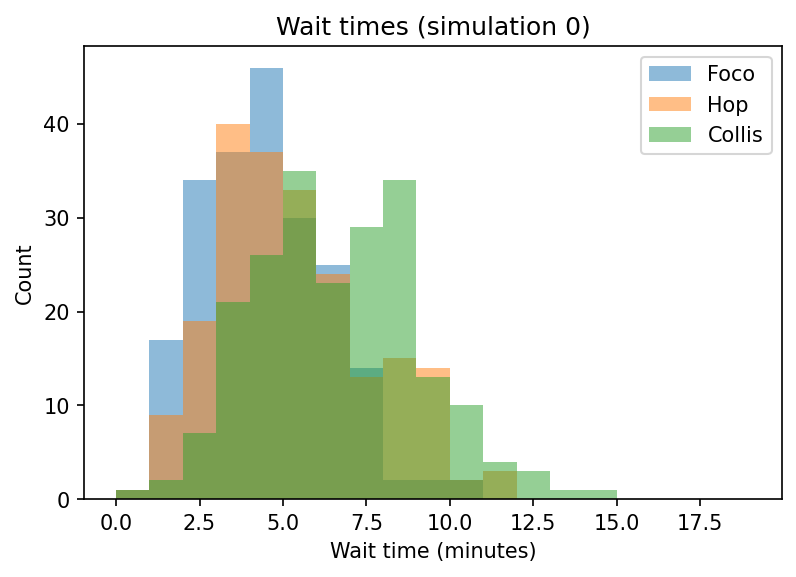

In [33]:
plt.hist(wait_times[0, :, 0], bins=np.arange(wait_times.max()), alpha=.5, label='Foco')
plt.hist(wait_times[0, :, 1], bins=np.arange(wait_times.max()), alpha=.5, label='Hop')
plt.hist(wait_times[0, :, 2], bins=np.arange(wait_times.max()), alpha=.5, label='Collis')
plt.legend()
plt.title('Wait times (simulation 0)')
plt.xlabel('Wait time (minutes)')
plt.ylabel('Count')

plt.show()

# "Same old same old" policy

One of the simplest strategies the student can follow is to always go to the dining venue with the lowest mean wait time given by $Q_t$, starting with initial estimate $Q_0(a) = 0$ for each action $a$. For example, she would start by going to each of Foco, Hop, and Collis once, pick the venue that had the shortest wait time (largest $Q_t(a)$), and continue to choose dining venues that maximize $Q_t$. This is known as a "greedy policy" [@pearl1984heuristics] because it always chooses actions that maximize the expected reward based on information so far. The greedy policy algorithm is given below.

1. Starting at timestep $t=0$, initialize for all actions $a$
    $$
    N_t(a) \leftarrow 0, Q_t(a) \leftarrow 0
    $$
2. Pick action $a$ that maximizes $Q_t(a)$, breaking ties randomly
3. Increment visit count for chosen $a$ and update estimate $Q_t(a)$
    $$
    N_{t+1}(a) \leftarrow N_t(a) + 1, Q_{t+1}(a) \leftarrow Q_t(a)  + \frac{1}{N_{t+1}(A)} [r_{t} - Q_t(a)]
    $$
4. Increment the timestep $t \leftarrow t + 1$, stop when $t = T$

In [35]:
chosen_wait_times = np.zeros((wait_times.shape[0], 70*3))
regret = np.zeros((wait_times.shape[0], 70*3))

In [36]:
for _ in range(wait_times.shape[0]):
    N = np.zeros((3,))
    Q_estimate = np.zeros((3,))
    actions = np.zeros((wait_times.shape[1],), dtype=int)
    for i in range(wait_times.shape[1]):
        a = Q_estimate.argmin()
        actions[i] = a
        w = wait_times[_, i, a]
        chosen_wait_times[_, i] = w
        N[a] += 1
        Q_estimate[a] = Q_estimate[a] + 1/N[a]*(w - Q_estimate[a])
    regret[_, :] = chosen_wait_times[_, :] - wait_times[_, :, lambdas.argmin()]

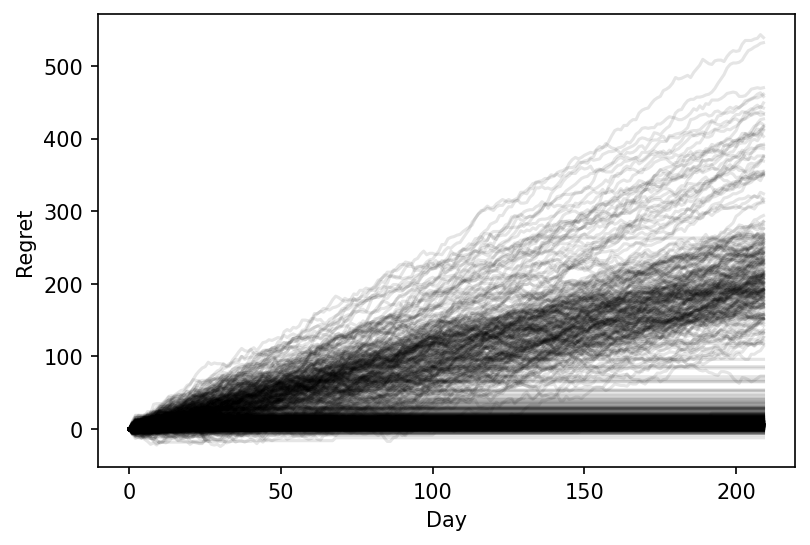

In [54]:
plt.plot(regret.cumsum(axis=1).T, color='k', alpha=.1)
plt.xlabel('Day')
plt.ylabel('Regret')
plt.show()

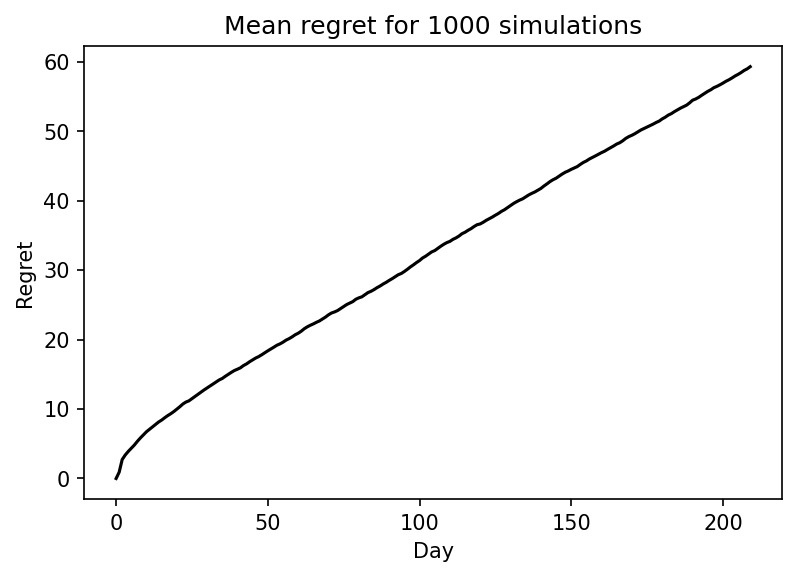

In [55]:
plt.plot(regret.cumsum(axis=1).mean(axis=0), color='k')
plt.xlabel('Day')
plt.ylabel('Regret')
plt.title(f'Mean regret for {wait_times.shape[0]} simulations')
plt.show()

In [41]:
regret.sum(axis=1).mean()

59.275

We can see that the mean regret (how much more time the student waits compared to the optimal venue) increases linearly over the course of the academic year. This is far from an effective policy: if the student _eventually_ learned which dining venue had the lowest mean wait time and starting going there, the regret would plateu. The lack of such an asymptote is indicative of the poor strategy employed in a purely greedy policy.

# O-week exploration, then same old policy

Instead of employing a greedy policy right away, what if our student tries out different venues for the first two weeks of orientation ("O-week"), then settles on whichever had the lowest empirical wait time? This may be better than purely greedy search, because there is a period of _exploration_ to learn about the different wait time distributions followed by a period of _exploitation_ of that knowledge. This strategy is more commonly called "$\epsilon$-first strategy," and the procedure is given below.



1. For first $\epsilon T$ decisions (where $\epsilon \in (0, 1)$), pick random actions, and update the visit count for chosen $a$ (venue) and estimate $Q_t(a)$
    $$
    N_{t+1}(a) \leftarrow N_t(a) + 1, Q_{t+1}(a) \leftarrow Q_t(a)  + \frac{1}{N_{t+1}(a)} [r_{t} - Q_t(a)]
    $$
2. For last $(1-\epsilon)T$ decisions, follow the greedy policy as described above

In [56]:
chosen_wait_times = np.zeros((wait_times.shape[0], 70*3))
regret = np.zeros((wait_times.shape[0], 70*3))

In [57]:
for _ in range(wait_times.shape[0]):
    N = np.zeros((3,))
    Q_estimate = np.zeros((3,))
    actions = np.zeros((wait_times.shape[1],), dtype=int)
    for i in range(wait_times.shape[1]):
        if i < 14:
            a = np.random.randint(3)
        else:
            a = Q_estimate.argmin()
        actions[i] = a
        w = wait_times[_, i, a]
        chosen_wait_times[_, i] = w
        N[a] += 1
        Q_estimate[a] = Q_estimate[a] + 1/N[a]*(w - Q_estimate[a])
    regret[_, :] = chosen_wait_times[_, :] - wait_times[_, :, lambdas.argmin()]

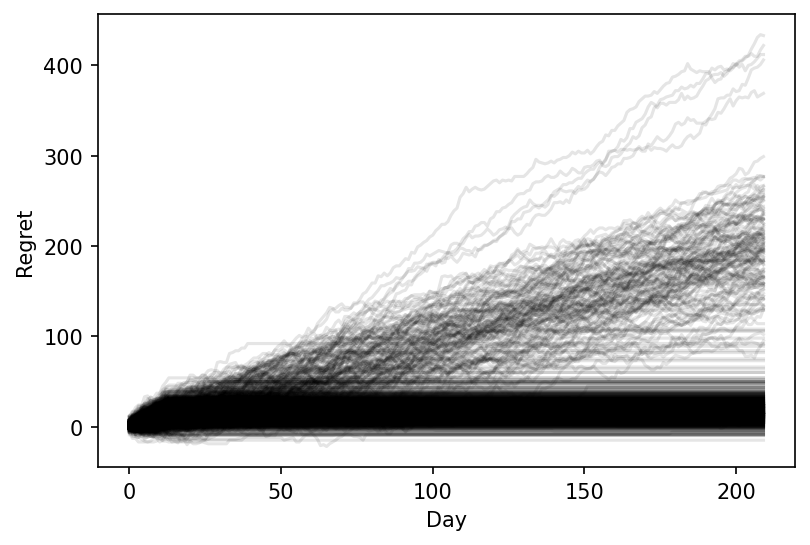

In [58]:
plt.plot(regret.cumsum(axis=1).T, color='k', alpha=.1)
plt.xlabel('Day')
plt.ylabel('Regret')
plt.show()

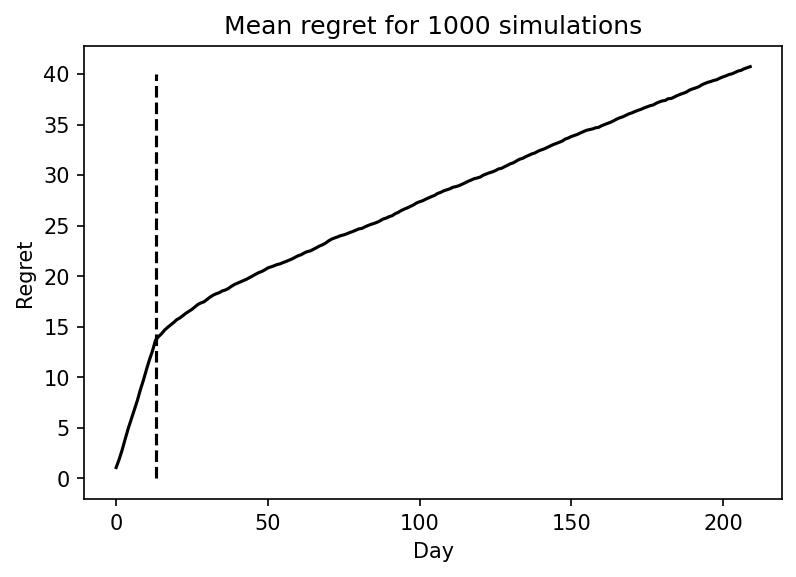

In [63]:
plt.plot(regret.cumsum(axis=1).mean(axis=0), color='k')
plt.vlines(x=13, ymin=0, ymax=40, color='k', linestyle='dashed')
plt.xlabel('Day')
plt.ylabel('Regret')
plt.title(f'Mean regret for {wait_times.shape[0]} simulations')
plt.show()

In [64]:
regret.sum(axis=1).mean()

40.719

$\epsilon$-first policy performs better than greedy policy, as illustrated by lower mean regret after 210 days (41 minutes compared to 59 minutes). The initial exploration improved the accuracy of the expected rewards in the Q function, which in turn increased the long-term expected rewards and decreased the wait times.

However, the regret still increases linearly after the 14-day exploration period. As with greedy policy, this indicates that the optimal policy is occasionally _never_ found. Can we do even better?

# Occasionally spontaneous policy

What if the student acts greedily _most_ of the time, but occasionally does something totally random? This strategy is commonly called $\epsilon$-greedy policy, where $\epsilon$ determines the probability of a random choice. The procedure is given below.

1. Starting at timestep $t=0$, initialize for all actions $a$
    $$
    N_t(a) \leftarrow 0, Q_t(a) \leftarrow 0
    $$
1. With probability $1-\epsilon$, picks action $a$ that maximizes $Q_t(a)$, breaking ties randomly, and with probability $\epsilon$, picks random action $a$
2. Increment visit count for chosen $a$ and update estimate $Q_t(a)$
    $$
    N_{t+1}(a) \leftarrow N_t(a) + 1, Q_{t+1}(a) \leftarrow Q_t(a)  + \frac{1}{N_{t+1}(A)} [r_{t} - Q_t(a)]
    $$
3. Increment the timestep $t \leftarrow t + 1$, stop when $t = T$

This policy includes exploration throughout the decision-making process.

In [102]:
epsilon_array = np.array([.02, .05, .1, .2])

In [103]:
chosen_wait_times = np.zeros((epsilon_array.shape[0], wait_times.shape[0], 70*3))
regret = np.zeros((epsilon_array.shape[0], wait_times.shape[0], 70*3))

In [104]:
for e_ind, epsilon in enumerate(epsilon_array):
    for _ in range(wait_times.shape[0]):
        N = np.zeros((3,))
        Q_estimate = np.zeros((3,))
        actions = np.zeros((wait_times.shape[1],), dtype=int)
        for i in range(wait_times.shape[1]):
            if np.random.rand() > epsilon:
                a = Q_estimate.argmin()
            else:
                a = np.random.choice(Q_estimate.size)
            actions[i] = a
            w = wait_times[_, i, a]
            chosen_wait_times[e_ind, _, i] = w
            N[a] += 1
            Q_estimate[a] = Q_estimate[a] + 1/N[a]*(w - Q_estimate[a])
        regret[e_ind, _, :] = chosen_wait_times[e_ind, _, :] - wait_times[_, :, lambdas.argmin()]

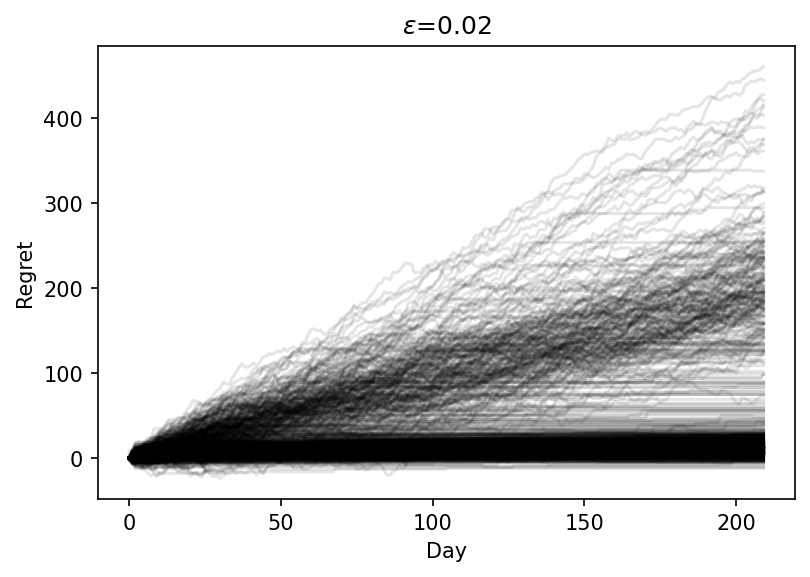

In [105]:
plt.plot(regret[0, ...].cumsum(axis=1).T, color='k', alpha=.1)
plt.xlabel('Day')
plt.ylabel('Regret')
plt.title(fr'$\epsilon$={epsilon_array[0]}')
plt.show()

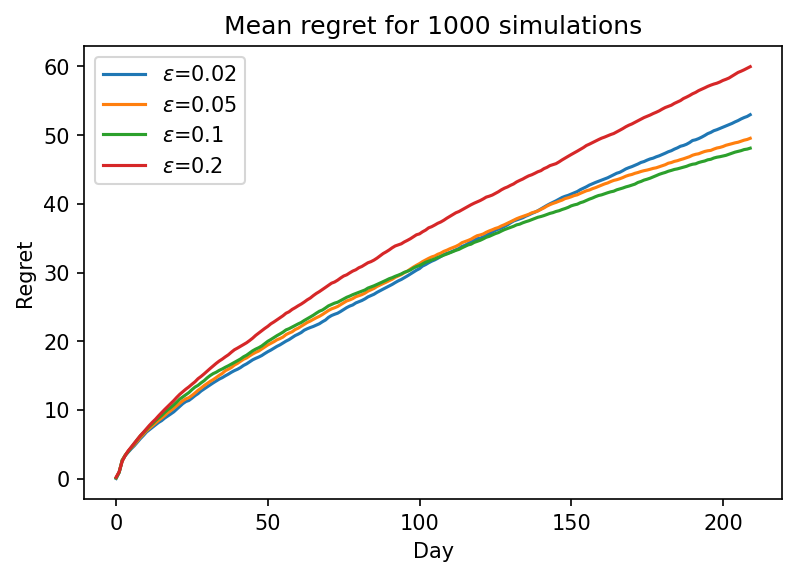

In [106]:
for e_ind, epsilon in enumerate(epsilon_array):
    plt.plot(regret[e_ind, ...].cumsum(axis=1).mean(axis=0), label=fr'$\epsilon$={epsilon}')
plt.xlabel('Day')
plt.ylabel('Regret')
plt.title(f'Mean regret for {wait_times.shape[0]} simulations')
plt.legend()
plt.show()

In [107]:
regret.sum(axis=2).mean(axis=1)

array([52.981, 49.545, 48.104, 59.972])

Using the $\epsilon$-greedy policy with $\epsilon=.05$ (the best value based on simulation results), the student's regret by the end of the year is 48 minutes, better than a purely greedy policy but not as effective as the $\epsilon$-first strategy. However, there is one important note to make. The regret curves above for $\epsilon$-greedy policy appear to have negative second derivatives. This indicates that--averaged over many simulations--the student continues to update her knowledge of the different dining venue wait times and eventually learns which venue has the shortest wait time. One can imagine that for a longer time horizon (two years instead of a single year) following an $\epsilon$-greedy policy would lead to lower regret.

# The time-crunched math major policy

Suppose that the student studies math, so she understands she needs to balance maximizing the estimated expected reward while also reducing uncertainty in those estimates. She also is fine with taking a few extra seconds to calculate the optimal policy. One way she can do this is by picking a venue that maximizes an "upper confidence bound (UCB)" on the expected reward. As the name suggests, the UCB is the reward value below which the student is confident the actual expected reward lies (for some degree of confidence). This idea was introduced by @LAI19854, @kaelbling1993learning, and @Agrawal1995. The particular UCB algorithm presented below is known as UCB1 [@auer2002finite].

The UCB formula is given below

$$
\text{UCB}_t(a) = Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}}
$$

The first term is simply the estimate of expected rewards $Q_t$. The second term characterizes the level of confidence in the estimate, where $c$ is a constant that controls the relative weight of exploration and exploitation.
When a particular action $a$ is chosen many times, $N_t(a)$ increases, and the confidence bound decreases, thus de-prioritizing choosing $a$ for exploratory purposes. The logarithm of $t$ in the numerator ensures that exploration continues as $t$ increases, but becomes less relevant over time.
For $c=0$, we recover a purely greedy policy.

The UCB policy is simply selecting the action that maximizes the UCB formula above, breaking ties randomly.
$$
a_t \leftarrow {\arg \max}_a \left[ \text{UCB}_t(a) \right]
$$

In [113]:
c_array = np.array([.5, 1, 2, 4])

In [114]:
chosen_wait_times = np.zeros((c_array.shape[0], wait_times.shape[0], 70*3))
regret = np.zeros((c_array.shape[0], wait_times.shape[0], 70*3))

In [115]:
for c_ind, c in enumerate(c_array):
    for _ in range(wait_times.shape[0]):
        N = np.zeros((3,))
        Q_estimate = np.zeros((3,))
        actions = np.zeros((wait_times.shape[1],), dtype=int)
        for i in range(wait_times.shape[1]):
            ucb_score = -Q_estimate + c * np.sqrt(np.log(i + 1) / (N + 1e-100))
            a = ucb_score.argmax()
            actions[i] = a
            w = wait_times[_, i, a]
            chosen_wait_times[c_ind, _, i] = w
            N[a] += 1
            Q_estimate[a] = Q_estimate[a] + 1/N[a]*(w - Q_estimate[a])
        regret[c_ind, _, :] = chosen_wait_times[c_ind, _, :] - wait_times[_, :, lambdas.argmin()]

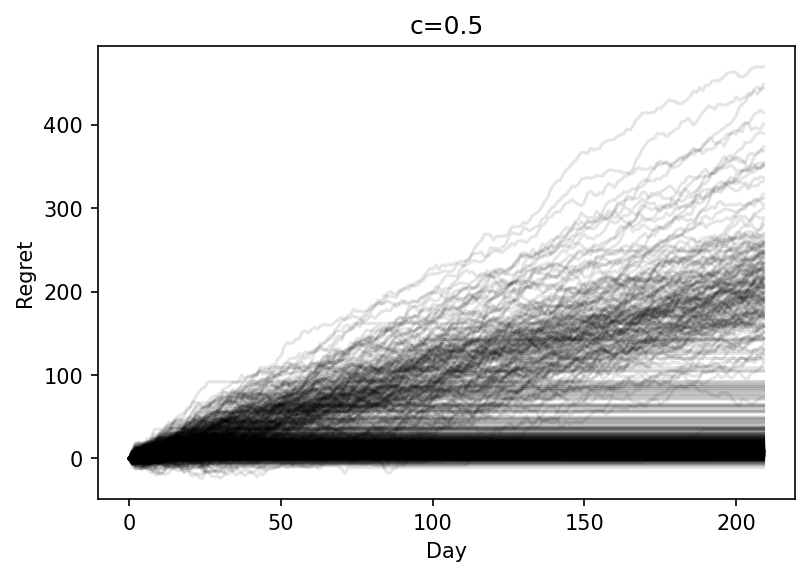

In [116]:
plt.plot(regret[0, ...].cumsum(axis=1).T, color='k', alpha=.1)
plt.xlabel('Day')
plt.ylabel('Regret')
plt.title(f'c={c_array[0]}')
plt.show()

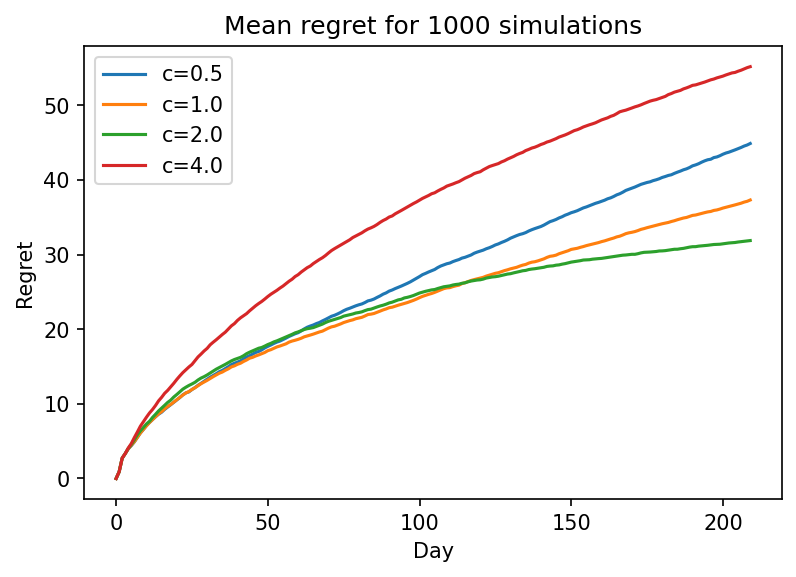

In [117]:
for c_ind, c in enumerate(c_array):
    plt.plot(regret[c_ind, ...].cumsum(axis=1).mean(axis=0), label=f'c={c}')
plt.xlabel('Day')
plt.ylabel('Regret')
plt.title(f'Mean regret for {wait_times.shape[0]} simulations')
plt.legend()
plt.show()

In [121]:
regret.sum(axis=2).mean(axis=1)

array([44.901, 37.328, 31.891, 55.199])

The UCB policy with an exploration factor of $c=2$ performed the best out of all strategies: the total regret after a year is 31 minutes, compared to 41 minutes using $\epsilon$-first and 48 minutes using $\epsilon$-greedy. And each regret curve appears to asymptote to a constant regret value, though at different time scales.

# Comparison of policies

Of all the policies considered here, UCB performed the best with the lowest regret after 210 days. This is understandable, as it explicitly balances exploration and exploitation in the UCB formula. We also considered the best exploration factor from the UCB policy, whereas the greedy policy and the $\epsilon$-first policies were not optimized over any parameters.

However, the UCB policy also is more computationally involved than the other policies. For the dining problem in particular, the student may not care enough to calculate each UCB value to decide where to eat each night. In contrast, $\epsilon$-first and $\epsilon$-greedy policies are more straightforward to follow, and have modestly higher regret compared to UCB. The additional 10 minutes of regret for $\epsilon$-first may be a worthwhile tradeoff for the student, especially considering this works out to under three seconds per dining decision!

# Other considerations

The version of the dining problem considered in this paper is intentionally simple so we can clearly examine how different decision-making policies affect the student's wait time. However, there are many additional complexities that can be added to make the dining problem more realistic and more complicated.

First, the wait time distributions at each venue may not be stationary. For example, the Hop may be very popular one term, but the next term it is less popular due to the changing student population (from matriculating and graduating students, as well as off terms). In this scenario, a policy that accounts for the non-stationary distribution would perform better than one that assumes the distributions remain constant in time.

Second, the wait times may depend on factors other than the dining venue. For example, it may be that the Hop has short wait times during weekdays, but very long wait times during weekends. For multi-armed bandits, this is known as a "contextual bandit," where the distribution that is sampled from depends on _both_ the action chosen _and_ an additional state variable.

Finally, and perhaps most importantly, the student's utility function may not be restricted to how long she waits for food. She may also care about which food she eats! Further, she may want to get dinner with a friend (thus picking venues that can facilitate social time), or may want to save money and go to the less expensive venues. Each of these are common factors that people consider when deciding to eat, and it would be fascinating to model behavior by including these in a generalized utility function.